In [1]:
# Python notebook to study the effects of improper BBoxes fed to NEMO classifier

import time, os, sys, warnings
import os.path as osp
import numpy as np

%matplotlib inline
from pylab import *
import pydot
import matplotlib.patches as patches

import caffe
import pynemo
from PIL import ImageDraw, Image
import csv
from caffe import layers as L, params as P
from caffe.proto import caffe_pb2
import caffe.draw

from IPython.display import Image, display

import cv2
from PIL import Image
# from easydict import EasyDict as edict
# from easydict import EasyDict

caffe.set_device(1)
caffe.set_mode_gpu()

In [2]:
# get the data loader here

# Helper functions for loading data

def get_cord(txt_loc):
    cord = []
    with open(txt_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')		
        cord_arr = np.zeros(4) 
        for row in reader:
            """
            The below stuff is required if the a$$nuckle who created the bboxes txt file didn't tab delimit 
            but instead used spaces
            """
            if (len(row) == 1):
                row = row[0].split()
            img_class = row[0]
            cord.append(row[0])
            cord_arr[0] = float(row[4])
            cord_arr[1] = float(row[5])
            cord_arr[2] = float(row[6])
            cord_arr[3] = float(row[7])
            cord.append(cord_arr)
            cord_arr = np.zeros(4)
    f.close()
    return cord

def data_loader(path, mode, return_img = False):
    """
    Function to load image locations, corresponding classes and BBoxes contained withing a list file

    return:
    A list with each individual image of the form
    [Image_location in str, Image_Class, BBox in []]
    """
    # Reference the directory of the GVDL folder
    img_loc = path + mode + '.list'
    data = [] 
    with open(img_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')		
        for row in reader:
            # seperate test-case for COCO
            if (path[-5:-1] == 'COCO'):   
                text = row[0][0:5] + '-labels/' + row[0][-16:-3] + 'txt'
            # for VOC and GVDL-D
            else:
                if (mode == 'test'):
                    text = row[0][0:5] + 'labels'+ row[0][11:-3] + 'txt' 
                if (mode == 'validation'):
#                     print(row[0])
#                     print(row[0][0:11]+ 'labels'+ row[0][15:-3])
                    text = row[0][0:11] + 'labels'+ row[0][17:-3] + 'txt' 
                if (mode == 'train'):
#                     print(row[0])
#                     print(row[0][0:6]+ 'labels'+ row[0][12:-3])
                    text = row[0][0:6] + 'labels' + row[0][12:-3] + 'txt'
            cord = get_cord(path + text)
#             print(cord[1])
            img = Image.open(path + row[0])
            if (len(np.shape(img))!=3):
                img = np.asarray(img)
                img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
#             print(np.shape(img))
            cord[1] = normalized_cord(img,cord[1])
#             print(cord[1])
            if (return_img == False):
                data.append([path + row[0], cord])
            else:
#                 print("Demanding images")
                data.append([Image.open(path + row[0]), cord])
                
    """ The following code is to verify the dataloader 
        Please give the index of the image file you want to load; the code will take care of the txt file
        To verify, give a particular index
    """
#     print(len(data))
    return data

def normalized_cord(image, cord):
#     function to normalize the cordinates
    y, x,_ = np.shape(image)
    x_top, y_top, x_bottom, y_bottom = cord
    return x_top/x, y_top/y, x_bottom/x, y_bottom/y

In [3]:
# To load the GVDL data
data_train = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/GVDL-D/', 'train', return_img = False)
data_test = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/GVDL-D/', 'validation', return_img = False)
# data_valid = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/GVDL-D/', 'validation', return_img = False)

In [4]:
def loadBatch(net, processed_ims):
    
    num_images = len(processed_ims)
    max_shape = np.array([im.shape for im in processed_ims]).max(axis=0)
    
    # Blob placeholder
    blob = np.zeros((num_images, max_shape[0], max_shape[1], 3),dtype=np.float32)

    
    # load images into blob placeholder
    #==================================================
    for i in range(num_images):
        im = processed_ims[i]
#         print(i)
        blob[i, 0:im.shape[0], 0:im.shape[1], :] = im
    

    # Change Channels in Caffe format
    #==================================================
    channel_swap = (0, 3, 1, 2)   # Original    
    blob = blob.transpose(channel_swap)


#     im_scales = np.array(im_scale_factors)

    blobs = {'data' : None}
    blobs['data'] = blob
    im_blob = blobs['data']
    # reshape network inputs
    net.blobs['data'].reshape(*(blobs['data'].shape))
    return {'data': blobs['data'].astype(np.float32, copy=False)}

In [5]:
def forward(img, cord):
#     print(cord)
    net =  caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-512.prototxt',
                     '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-512.caffemodel',
                     caffe.TEST)
    blobs_out = net.forward(**loadBatch(net,[img]))
#     print(np.shape(img))
#     out = loadBatch(net,img)
    mydata = net.blobs['cascade192/output'].data
#     index = 0
#     output = np.squeeze(mydata[0,index,:,:])
#     plt.imshow(output)
    
    
#     must get the labels ready
#     print(np.shape(mydata.tolist()))
#     print(np.shape(cord))
    cord = np.reshape(cord,(1,1,1,5))

#     print(np.shape(cord))
    net3 = caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/complete_model_gorchnet.prototxt',
                     '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-ROI.caffemodel',
                    caffe.TEST)
    net3.blobs['data'].data[...] = mydata.tolist()
    net3.blobs['bboxes'].data[...] = cord.tolist()
    class_output = net3.forward()
    out =  net3.blobs['global_pool'].data
    roi = net3.blobs['roi_pool'].data
#     print(np.shape(net3.blobs['roi_pool'].data[...]))
#     print(np.shape(out))
    return out

In [6]:
# Following fucntion comes with Image visualization; for main purpose use the scale_cord function
def update_cord(cord_arr,scale = 1):
    #  function to display the image being passed to the network 
    x_top, y_top, x_bottom, y_bottom = cord_arr[1:]
    img_dim = 1
    center = np.array([(x_top + x_bottom)/2, (y_top + y_bottom)/2])
    dims = np.array([x_bottom-center[0],y_bottom-center[1]])
    x_center, y_center = center[0], center[1]
    x_top = x_center-dims[0]*scale
    if (x_top < 0):
        x_top = 0
    y_top = y_center-dims[1]*scale
    if (y_top < 0):
        y_top = 0
    x_bottom = x_center+dims[0]*scale
    if (x_bottom > img_dim):
        x_bottom = img_dim
    y_bottom = y_center+dims[1]*scale
    if (y_bottom > img_dim):
        y_bottom = img_dim
    new_cord = np.array([0,x_top/img_dim, y_top/img_dim, x_bottom/img_dim, y_bottom/img_dim])
    return new_cord

In [7]:
def display_img(img, cord_arr,scale = 1):
#     function to display the image being passed to the network 
    cord_arr = update_cord(cord_arr, scale)
    x_top, y_top, x_bottom, y_bottom = cord_arr[1:]
    x_top, y_top, x_bottom, y_bottom = int(x_top*512), int(y_top*512), int(x_bottom*512), int(y_bottom*512) 
    center = np.array([(x_top + x_bottom)/2, (y_top + y_bottom)/2])
    dims = np.array([x_bottom-center[0],y_bottom-center[1]])
    x_center, y_center = int(center[0]), int(center[1])
#     print("The center of the BBox",x_center, y_center)
#     print("The dimensions are ", dims/2)
#     print("The original cordinates of the BBox",x_top, y_top, x_bottom, y_bottom)
    x_top = int(abs(x_center-dims[0]))
    y_top = int(abs(y_center-dims[1]))
    x_bottom = int(abs(x_center+dims[0]))
    y_bottom = int(abs(y_center+dims[1]))
#     print("The new cordinates of the BBox",x_top, y_top, x_bottom, y_bottom)
    cv2.rectangle(img,(x_top,y_top),(x_bottom,y_bottom),(0,255,0),3)
#     x_top, y_top, x_bottom, y_bottom = x_top * scale, y_top * scale, x_bottom * scale, y_bottom * scale 
    x_top = int(x_center-dims[0]*scale)
#     print(x_center, x_top)
    if (x_top < 0):
        x_top = 0
    y_top = int(y_center-dims[1]*scale)
    if (y_top < 0):
        y_top = 0
    x_bottom = int(x_center+dims[0]*scale)
    if (x_bottom > 512):
        x_bottom = 512
    y_bottom = int(y_center+dims[1]*scale)
    if (y_bottom > 512):
        y_bottom = 512
#     print("The cordinates of the BBox",x_top, y_top, x_bottom, y_bottom)
    cv2.rectangle(img,(int(x_top),int(y_top)),(int(x_bottom),int(y_bottom)),(255,0,0),3)
    fig1,ax1 = plt.subplots(1)
    ax1.imshow(img)
    new_cord = np.array([0,x_top, y_top, x_bottom, y_bottom])
#     plt.imshow(img)
    return new_cord.tolist()

In [27]:
# Below is the code for translation
processed_ims2, gt_cord_arr2, gt_label_list2 = process_data(data_test)

# img_loc = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.jpg'
# txt_loc = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.txt'
# x_top, y_top, x_bottom, y_bottom = get_cord(txt_loc)
# img = Image.open(img_loc)
# display_img(img, )

159


In [104]:
# xmin ymin xmax ymax
def IOUCalc(boxes, query_boxes):
    """
    determine overlaps between boxes and query_boxes
    :param boxes: n * 5 bounding boxes (4 + 1 for objectness)
    :param query_boxes: k * 5 bounding boxes (4 + 1 for objectness)
    :return: overlaps: n * k overlaps
    """
    #overlaps = np.zeros((n_, k_), dtype=np.float)
    #for k in range(k_):
    query_box_area = (query_boxes[3] - query_boxes[1] + 1) * (query_boxes[4] - query_boxes[2] + 1)
    #for n in range(n_):
    iw = min(boxes[3], query_boxes[3]) - max(boxes[1], query_boxes[1]) + 1
    if iw > 0:
        ih = min(boxes[4], query_boxes[4]) - max(boxes[2], query_boxes[2]) + 1
    if ih > 0:
        box_area = (boxes[3] - boxes[1] + 1) * (boxes[4] - boxes[2] + 1)
        all_area = float(box_area + query_box_area - iw * ih)
        overlaps = iw * ih / all_area
    return overlaps

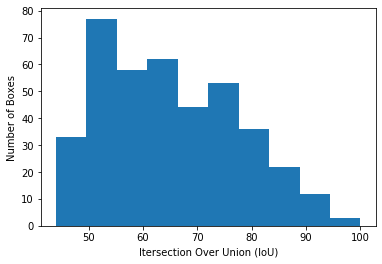

In [146]:
def get_IOU(cord_test, update_arr):
    overlap = np.zeros([len(update_arr)])
    for i in range(len(update_arr)):
        overlap[i] = int(IOUCalc(cord_test*512, update_arr[i]*512)*100)
    return overlap

# The main translation code
def translate(img_test, cord_test):
    shape,_,_ = np.shape(img_test) 
    x_top, y_top, x_bottom, y_bottom = cord_test[1:]-0.2
    # print(cord_test[1:], cord_test[1:] - 0.2)
    update_list = []
    for i in range (0,20):#0,0.4,0.02
        for j in range (0,20):
            top_x = x_top + i/50
            top_y = y_top + j/50 
            bottom_x = x_bottom + i/50
            bottom_y = y_bottom + j/50
            if (top_x < 0):
                top_x = 0
            if (top_y < 0):
                top_y = 0
            if (bottom_x > 1):
                bottom_x = 1
            if (bottom_y > 1): 
                bottom_y = 1
    #         print((bottom_x - top_x)* (bottom_y - top_y))
            cv2.rectangle(img_test,(int(top_x*512),int(top_y*512)),(int(bottom_x*512),int(bottom_y*512)),(255,0,0),3)
            update_list.append(np.array([0,top_x, top_y, bottom_x, bottom_y]))
    #         fig1,ax1 = plt.subplots(1)
    #         ax1.imshow(img_test)
    # plt.imshow(img_test)
    return np.asarray(update_list)

def plot_hist(overlap):
    fig,ax = plt.subplots(1)
    ax.hist(overlap)
    plt.xlabel('Itersection Over Union (IoU)')
    plt.ylabel('Number of Boxes')
#     plt.title('Distribution of Boxes')

index = 100
img_test = processed_ims2[index]
cord_test = gt_cord_arr2[index]
update_arr = translate(img_test, cord_test)

overlap = get_IOU(cord_test, update_arr)
plot_hist(overlap)

In [8]:
def process_data(data):
    print(len(data))
    img_list = []
    gt_label_list = []
    gt_cord_list = []
    pad = np.zeros((len(data),1))
    for i in range(len(data)):
        img_list.append(data[i][0])
        gt_label_list.append(data[i][1][0])
        gt_cord_list.append(data[i][1][1])
    # print(gt_cord_list)
    gt_cord_arr = np.asarray(gt_cord_list)
    gt_cord_arr = np.hstack((pad, gt_cord_arr))
#     print(gt_cord_arr[0])
    im_batch = img_list   # Pass the batch
    num_images = len(im_batch)
    processed_ims = []
    im_scale_factors = []  #for multiscale processing

    for j,im_file  in enumerate(im_batch):
    #     print(im_file)
        im = cv2.imread(im_file)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
#         plt.imshow(im)

        # Retype and normilize image
        #-------------------------------------------
        im_orig = im.astype(np.float32, copy=True)
        im_orig /= 255
        im_orig -= .5


        # Get shape and Max and Min of an image
        #-------------------------------------------
        im_shape = im_orig.shape
    #     print(im_shape)
        im_size_min = np.min(im_shape[0:2])
        im_size_max = np.max(im_shape[0:2])


        target_size = 512
        im_scale = float(target_size) / float(im_size_min)

        #--------------------------------------------------------------
        # Future: multiscale load
        # Prevent the biggest axis from being more than MAX_SIZE
        #if np.round(im_scale * im_size_max) > MAX_SIZE:
        #    im_scale = float(MAX_SIZE) / float(im_size_max)
        #--------------------------------------------------------------
        imW = (im_shape[1])
        imH = (im_shape[0])

        target_size = 512
        im_scaleX = float(target_size) / float(imW)
        im_scaleY = float(target_size) / float(imH)

        im = cv2.resize(im_orig, None, None, fx=im_scaleX, fy=im_scaleY, interpolation=cv2.INTER_LINEAR)

    #     im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR)
    #     print(im.shape)

        im_scale_factors.append(im_scale)

        processed_ims.append(im)
#     print(np.shape(processed_ims))
    return processed_ims, gt_cord_arr, gt_label_list
    
processed_ims, gt_cord_arr, gt_label_list = process_data(data_train)
processed_ims_test, gt_cord_arr_test, gt_label_list_test = process_data(data_test)

131
159


In [9]:
# for training 
input_vec = []
input_vec_test = []
for i in range(len(processed_ims)):
    out = forward(processed_ims[i], gt_cord_arr[i])
    input_vec.append(np.reshape(out,(128)))

# insert the update function in here
gt_cord_arr_new_test = np.zeros(np.shape(gt_cord_arr_test))
for i in range(len(gt_cord_arr_test)):
    gt_cord_arr_new_test[i] = update_cord(gt_cord_arr_test[i], 0.1) # Change the BBox scale here
#     print(gt_cord_arr_new_test[i],gt_cord_arr_test[i])

# for testing
for i in range(len(processed_ims_test)):
    index = 110
    out = forward(processed_ims_test[i], gt_cord_arr_new_test[i])
    input_vec_test.append(np.reshape(out,(128)))

In [11]:
print(np.shape(input_vec))
print(np.shape(input_vec_test))

nemo = pynemo.nemo(dominance= 1.25, m_learningRate=1)
nemo.learn(inputs = np.asarray(input_vec), labels = np.asarray(gt_label_list))

(131, 128)
(159, 128)


131

In [12]:
def evaluate(test_vec):
    predictions = nemo.predict_proba(test_vec, omit_nothing = False)
#     print(predictions)
    preds = predictions.idxmax(axis=1)
    pred_class = [preds[i] for i in range (len(preds))]
    return pred_class

def evaluate_nemo(truth, pred):
    correct_class = []
    wrong_class_gt = []
    wrong_class_pred = []
    score = 0
    for i in range(len(truth)):
#         print(truth[i], pred[i]) 
        if (truth[i] == pred[i]):
            score += 1
            correct_class.append(truth[i])
        else:
            wrong_class_gt.append(truth[i])
            wrong_class_pred.append(pred[i])
    return score, wrong_class_gt, wrong_class_pred, correct_class

print(np.shape(input_vec_test))
pred = evaluate(input_vec_test)
truth = gt_label_list_test 
print(len(truth), len(pred))
score, wrong_gt, wrong_pred, correct_pred = evaluate_nemo(truth, pred)

(159, 128)
159 159


In [13]:
True_Positive = {x:correct_pred.count(x) for x in sorted(correct_pred)}
False_Positive = {x:wrong_pred.count(x) for x in sorted(wrong_pred)}
False_Positive2 = {x:wrong_pred.count(x) for x in sorted(correct_pred)}  # Does not include the 'Nothing I Know' class 
print(True_Positive)
print(False_Positive)
print(False_Positive2)
TP_keys = np.fromiter(True_Positive.values(), dtype=int)
FP_keys = np.fromiter(False_Positive2.values(), dtype=int)
# print(TP_keys)
# print(FP_keys)
print([TP_keys[i]/(TP_keys[i] + FP_keys[i]) for i in range(len(TP_keys))])
prec = np.asarray([TP_keys[i]/(TP_keys[i] + FP_keys[i]) for i in range(len(TP_keys))])
print("The Mean Precision is", np.mean(prec))

{'baguette': 11, 'coin': 4, 'eiffel': 13, 'keys': 4, 'pen': 10, 'platypus': 4, 'spinner': 11, 'squirrel': 3}
{'Nothing I know': 41, 'baguette': 16, 'coin': 5, 'eiffel': 2, 'keys': 8, 'pen': 9, 'platypus': 3, 'spinner': 1, 'squirrel': 13, 'vr': 1}
{'baguette': 16, 'coin': 5, 'eiffel': 2, 'keys': 8, 'pen': 9, 'platypus': 3, 'spinner': 1, 'squirrel': 13}
[0.4074074074074074, 0.4444444444444444, 0.8666666666666667, 0.3333333333333333, 0.5263157894736842, 0.5714285714285714, 0.9166666666666666, 0.1875]
The Mean Precision is 0.5317203599275968


In [14]:
classes=['baguette', 'coin', 'duck', 'eiffel', 'keys', 'pen', 'platypus', 'spinner', 'squirrel','vr']
classes

['baguette',
 'coin',
 'duck',
 'eiffel',
 'keys',
 'pen',
 'platypus',
 'spinner',
 'squirrel',
 'vr']

In [192]:
# for scale = 0.65
arr0 = [0.6, 1.0, 1.0, 1.0, 0.5882352941176471, 0.7619047619047619, 0.7222222222222222, 1.0, 0.8461538461538461, 1.0]

# for scale = 0.7
arr1 = [0.6521739130434783, 0.9166666666666666, 1.0, 1.0, 0.7333333333333333, 0.85, 0.75, 0.9444444444444444, 0.9090909090909091, 1.0]

# for scale = 0.75
arr2 = [0.7142857142857143, 0.9166666666666666, 1.0, 1.0, 0.6470588235294118, 0.8421052631578947, 0.7, 1.0, 0.9, 1.0]

# for scale = 0.8
arr3 = [0.7142857142857143, 0.9166666666666666, 1.0, 1.0, 0.75, 0.8947368421052632, 0.7368421052631579, 1.0, 0.9090909090909091, 1.0]

# for scale = 0.85
arr4 = [0.8333333333333334, 1.0, 0.8461538461538461, 1.0, 0.7333333333333333, 0.8421052631578947, 0.7368421052631579, 1.0, 0.9090909090909091, 1.0]


# for scale = 0.9
arr5 = [0.75, 1.0, 1.0, 1.0, 0.6842105263157895, 0.9333333333333333, 0.7777777777777778, 1.0, 0.8461538461538461, 1.0]

# for scale = 0.95
arr6 = [0.7894736842105263, 0.9285714285714286, 1.0, 1.0, 0.8, 0.9444444444444444, 0.7777777777777778, 0.9411764705882353, 0.9166666666666666, 1.0]

# for scale = 1
arr7 = [0.7142857142857143, 1.0, 1.0, 1.0, 0.75, 0.9411764705882353, 0.7647058823529411, 0.9444444444444444, 1.0, 0.875]

# for scale = 1.05
arr8 = [0.75, 1.0, 1.0, 1.0, 0.8125, 0.9411764705882353, 0.7777777777777778, 0.9444444444444444, 1.0, 1.0]

# for scale = 1.1
arr9 = [0.6818181818181818, 0.9285714285714286, 0.9285714285714286, 1.0, 0.6842105263157895, 0.9375, 0.8125, 0.9375, 1.0, 1.0]

# for scale = 1.15
arr10 = [0.6818181818181818, 0.9285714285714286, 1.0, 1.0, 0.6842105263157895, 0.9333333333333333, 0.8125, 0.9411764705882353, 1.0, 1.0]

# for scale = 1.20
arr11 = [0.6818181818181818, 0.9285714285714286, 0.9333333333333333, 1.0, 0.6842105263157895, 0.9375, 0.8125, 0.9375, 1.0, 1.0]

# for scale = 1.25
arr12 = [0.6818181818181818, 0.9285714285714286, 0.9333333333333333, 1.0, 0.7, 0.8823529411764706, 0.8125, 0.9375, 0.9166666666666666, 1.0]

# for scale = 1.3
arr13 = [0.6818181818181818, 0.9285714285714286, 0.9333333333333333, 1.0, 0.7368421052631579, 0.9333333333333333, 0.8125, 0.9411764705882353, 0.9166666666666666, 1.0]

# for scale = 1.35
arr14 = [0.6818181818181818, 0.9285714285714286, 0.9333333333333333, 1.0, 0.7368421052631579, 0.9375, 0.8125, 0.9411764705882353, 1.0, 1.0]

ratios = [0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05,1.10,1.15,1.20,1.25,1.30,1.35]

In [195]:
# for i in range(14):
#     print("arr" + str(i))
score_list = [arr0, arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8, arr9, arr10, arr11, arr12, arr13, arr4]
score_arr = np.asarray(score_list)
ratios_arr = np.asarray(ratios)
np.shape(score_arr)

(15, 10)

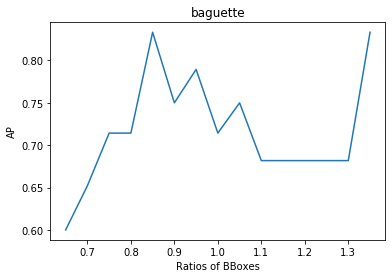

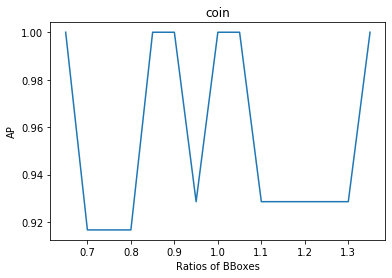

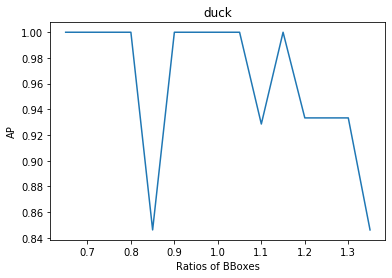

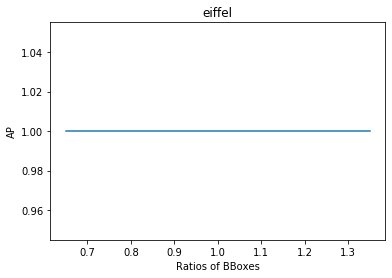

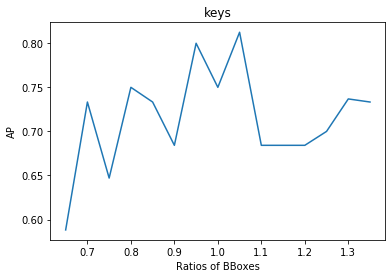

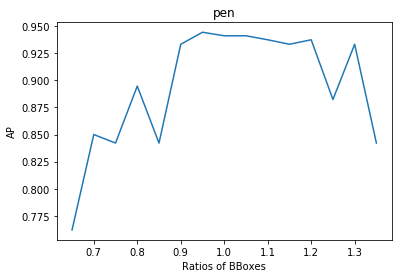

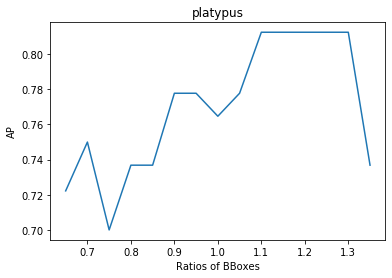

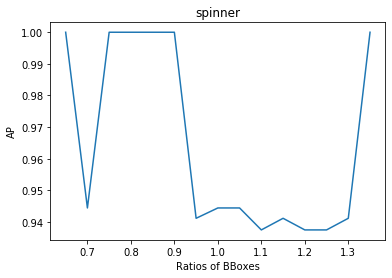

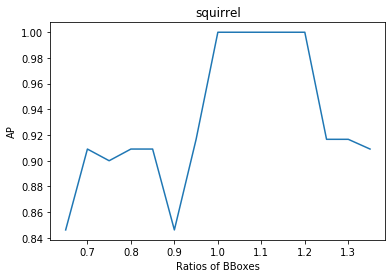

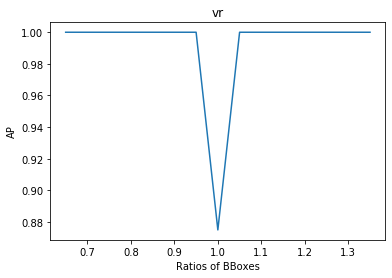

In [215]:
# score_arr[:,0]
for i in range(len(score_arr[0])):
#     print(classes[i])
    fig,ax = plt.subplots(1)
    ax.plot(ratios_arr, score_arr[:,i])
    plt.title(classes[i])
    plt.xlabel('Ratios of BBoxes')
    plt.ylabel('AP')
    
#     plt.show()

Text(0, 0.5, 'mean AP across classes')

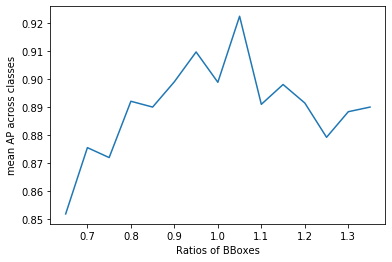

In [226]:
score_arr[:]
np.mean(score_arr, axis = 1)
fig,ax = plt.subplots(1)
ax.plot(ratios_arr, np.mean(score_arr, axis = 1))
plt.xlabel('Ratios of BBoxes')
plt.ylabel('mean AP across classes')
# for i in range(len(score_arr[0])):
#     fig,ax = plt.subplots(1)
#     ax.plot(ratios_arr, score_arr[:,i])
#     plt.title(classes[i])
#     plt.xlabel('Ratios of BBoxes')
#     plt.ylabel('AP')
    

In [47]:
print("End")
print("X-"*50)
print("-"*50)

End
X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-X-
--------------------------------------------------


In [4]:
# seperating data into image location, GT label and GT BBoxes
print(len(data))
img_list = []
gt_label_list = []
gt_cord_list = []
pad = np.zeros((len(data),1))
for i in range(len(data)):
    img_list.append(data[i][0])
    gt_label_list.append(data[i][1][0])
    gt_cord_list.append(data[i][1][1])
# print(gt_cord_list)
gt_cord_arr = np.asarray(gt_cord_list)
gt_cord_arr = np.hstack((pad, gt_cord_arr))
print(gt_cord_arr[0])

159
[0.      0.48369 0.62585 0.52398 0.71282]


In [5]:
def plot_blobs(net, layer, cols = 5, batchIndex = 0, figsize = (5,5), cmap = cm.get_cmap('viridis'),v=(0,1), byrow = False, idx = -1):
    
    # number of blobs annd their dimensions
    num_channels  = net.blobs[layer].data.shape[1]
    cont_height   = net.blobs[layer].data.shape[2]
    cont_width    = net.blobs[layer].data.shape[3]
    
    if  (not isinstance(idx, list)): idx=range(num_channels)
    num_channels = len(idx)
    
    rows = int(np.ceil(num_channels/cols))
    f, splt = plt.subplots(rows,cols,figsize=figsize)


    for c,curCh in enumerate(idx):
        content = (net.blobs[layer].data[batchIndex, curCh, :, :])
        
        if byrow==False:
            splt[c%rows,int(c/rows)].imshow(content, cmap = cm.get_cmap('viridis', 420),vmin = v[0],vmax=v[1])
        else:
            splt[int(c/rows),c%rows].imshow(content, cmap = cm.get_cmap('viridis', 420),vmin = v[0],vmax=v[1])
        
        
def plot_activation_hist(net, layer, cols = 5, batchIndex = 0, figsize = (5,5), cmap = cm.get_cmap('viridis'),v=(0,1), h=100, idx = -1):

    # number of blobs annd their dimensions
    num_channels  = net.blobs[layer].data.shape[1]
    cont_height   = net.blobs[layer].data.shape[2]
    cont_width    = net.blobs[layer].data.shape[3]
    
    if  (not isinstance(idx, list)): idx=range(num_channels)
    num_channels = len(idx)
    
    rows = int(np.ceil(num_channels/cols))
    f, splt = plt.subplots(rows,cols,figsize=figsize)

    for c,curCh in enumerate(idx):
    
        content = (net.blobs[layer].data[batchIndex, curCh, :, :])
        cc = content.reshape(1024)
        if byrow==False:
            splt[c%rows,int(c/rows)].hist(cc,h)
        else:
            splt[int(c/rows),c%rows].hist(cc,h)

In [6]:
# gt_label_list

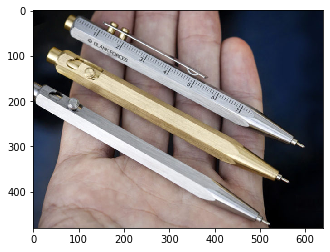

In [7]:
def get_cord(txt_location):
#     img = Image.open(img_location)
    #img = img.resize((512,512))
    with open(txt_location, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')
        cord = []
        cord_arr = np.zeros(4) 
        for row in reader:
            img_class = row[0]
            x_top = float(row[4])
            y_top = float(row[5])
            x_bottom = float(row[6])
            y_bottom = float(row[7])
    return x_top, y_top, x_bottom, y_bottom

# 	draw = ImageDraw.Draw(img)
# 	draw.rectangle(((x_top, y_top), (x_bottom, y_bottom)))
# 	print (img_class)
# 	img.show()


img_name = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.jpg'
txt_name = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.txt'
# x_top, y_top, x_bottom, y_bottom = get_cord(img_name, txt_name)
# img = Image.open(img_name)
# # img = cv2.imread(img_loc,0)
# draw = ImageDraw.Draw(img)
# draw.rectangle(((x_top, y_top), (x_bottom, y_bottom)))
# fig5,ax5 = plt.subplots(1)
# plt.title("GT Boxes")

# for tmpRect in myProposedRects:

# rect = patches.Rectangle(
#         (x_top,y_top),
#         x_bottom - x_top,
#         y_bottom - y_top,
#         linewidth=2,
#         edgecolor='r',
#         facecolor='none')
# ax5.add_patch(rect)

# ax5.imshow(img)

# plt.show()

#image_name='test_images/000456.jpg'
#image_name='test_images/duck512.jpg'
#image_name='test_images/enight.jpg'
# image_name='test_images/wduck.jpg'

# im_batch = [img_name] #quick test on one image
im_batch = img_list   # Pass the batch
num_images = len(im_batch)
processed_ims = []
im_scale_factors = []  #for multiscale processing

for j,im_file  in enumerate(im_batch):
#     print(im_file)
    im = cv2.imread(im_file)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    plt.imshow(im)

    # Retype and normilize image
    #-------------------------------------------
    im_orig = im.astype(np.float32, copy=True)
    im_orig /= 255
    im_orig -= .5


    # Get shape and Max and Min of an image
    #-------------------------------------------
    im_shape = im_orig.shape
#     print(im_shape)
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    
    target_size = 512
    im_scale = float(target_size) / float(im_size_min)

    #--------------------------------------------------------------
    # Future: multiscale load
    # Prevent the biggest axis from being more than MAX_SIZE
    #if np.round(im_scale * im_size_max) > MAX_SIZE:
    #    im_scale = float(MAX_SIZE) / float(im_size_max)
    #--------------------------------------------------------------
    imW = (im_shape[1])
    imH = (im_shape[0])

    target_size = 512
    im_scaleX = float(target_size) / float(imW)
    im_scaleY = float(target_size) / float(imH)

    im = cv2.resize(im_orig, None, None, fx=im_scaleX, fy=im_scaleY, interpolation=cv2.INTER_LINEAR)

#     im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR)
#     print(im.shape)

    im_scale_factors.append(im_scale)
    
    processed_ims.append(im)

In [8]:
np.shape(processed_ims)

(159, 512, 512, 3)

In [10]:
# complete forward pass including two networks

def forward(img, cord):
#     print(cord)
    net =  caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-512.prototxt',
                     '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-512.caffemodel',
                     caffe.TEST)
    blobs_out = net.forward(**loadBatch(net,[img]))
#     print(np.shape(img))
#     out = loadBatch(net,img)
    mydata = net.blobs['cascade192/output'].data
#     index = 0
#     output = np.squeeze(mydata[0,index,:,:])
#     plt.imshow(output)
    
    
#     must get the labels ready
#     print(np.shape(mydata.tolist()))
#     print(np.shape(cord))
    cord = np.reshape(cord,(1,1,1,5))

#     print(np.shape(cord))
    net3 = caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/complete_model_gorchnet.prototxt',
                     '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-ROI.caffemodel',
                    caffe.TEST)
    net3.blobs['data'].data[...] = mydata.tolist()
    net3.blobs['bboxes'].data[...] = cord.tolist()
    class_output = net3.forward()
    out =  net3.blobs['global_pool'].data
    roi = net3.blobs['roi_pool'].data
#     print(np.shape(net3.blobs['roi_pool'].data[...]))
#     print(np.shape(out))
    return out
#     print(mydata[0,index,:,:].shape)
#     output = np.squeeze(mydata[0,index,:,])
#     plt.imshow(mydata[0,index,:,:])
#     print(mydata[0,index,:,:])
#     print(np.min(output),np.max(output))
    
input_vec = []

# for training 
for i in range(len(processed_ims)):
    out = forward(processed_ims[i], gt_cord_arr[i])
    input_vec.append(np.reshape(out,(128)))
    print(gt_label_list[i])
#     output = np.squeeze(mydata[0,index,:,:])
#     plt.imshow(output)
    


eiffel
duck
squirrel
coin
platypus
baguette
pen
keys
spinner
vr
platypus
squirrel
platypus
platypus
platypus
coin
eiffel
pen
squirrel
duck
eiffel
pen
duck
baguette
pen
keys
platypus
baguette
keys
eiffel
keys
pen
platypus
keys
pen
keys
duck
coin
baguette
duck
spinner
coin
squirrel
keys
duck
baguette
duck
squirrel
pen
spinner
squirrel
baguette
eiffel
spinner
pen
keys
platypus
squirrel
eiffel
duck
vr
vr
keys
eiffel
spinner
keys
baguette
spinner
squirrel
vr
eiffel
spinner
duck
vr
platypus
keys
coin
duck
baguette
coin
platypus
eiffel
duck
pen
coin
platypus
pen
spinner
duck
eiffel
spinner
spinner
pen
platypus
squirrel
spinner
squirrel
spinner
vr
spinner
baguette
baguette
pen
eiffel
coin
platypus
keys
coin
eiffel
platypus
platypus
spinner
spinner
baguette
platypus
baguette
pen
squirrel
duck
keys
baguette
pen
keys
eiffel
vr
keys
squirrel
baguette
vr
duck
pen
duck
vr
coin
eiffel
eiffel
spinner
baguette
spinner
eiffel
vr
coin
duck
coin
pen
duck
eiffel
spinner
pen
coin
pen
keys
eiffel
platypus
pl

In [11]:
np.shape(np.asarray(input_vec))

(159, 128)

In [28]:
import pynemo
nemo = pynemo.nemo(dominance=1, m_learningRate=1)
nemo.learn(inputs = np.asarray(input_vec), labels = np.asarray(gt_label_list))

159

In [29]:
def evaluate(test_vec):
    predictions = nemo.predict_proba(test_vec, omit_nothing = False)
#     print(predictions)
    preds = predictions.idxmax(axis=1)
    pred_class = [preds[i] for i in range (len(preds))]
    return pred_class

def evaluate_nemo(truth, pred):
    correct_class = []
    wrong_class_gt = []
    wrong_class_pred = []
    score = 0
    for i in range(len(truth)):
#         print(truth[i], pred[i]) 
        if (truth[i] == pred[i]):
            score += 1
            correct_class.append(truth[i])
        else:
            wrong_class_gt.append(truth[i])
            wrong_class_pred.append(pred[i])
    return score, wrong_class_gt, wrong_class_pred, correct_class

pred = evaluate(input_vec)
truth = gt_label_list # passing the train as test!
score, wrong_gt, wrong_pred, correct_pred = evaluate_nemo(truth, pred)

In [30]:
True_Positive = {x:correct_pred.count(x) for x in sorted(correct_pred)}
False_Positive = {x:wrong_pred.count(x) for x in sorted(wrong_pred)}
False_Positive2 = {x:wrong_pred.count(x) for x in sorted(correct_pred)}  # Does not include the 'Nothing I Know' class 
print(True_Positive)
print(False_Positive)
print(False_Positive2)

{'baguette': 15, 'coin': 14, 'duck': 15, 'eiffel': 19, 'keys': 14, 'pen': 17, 'platypus': 18, 'spinner': 18, 'squirrel': 12, 'vr': 10}
{'baguette': 2, 'eiffel': 1, 'pen': 1, 'platypus': 2, 'vr': 1}
{'baguette': 2, 'coin': 0, 'duck': 0, 'eiffel': 1, 'keys': 0, 'pen': 1, 'platypus': 2, 'spinner': 0, 'squirrel': 0, 'vr': 1}


In [31]:
TP_keys = np.fromiter(True_Positive.values(), dtype=int)
FP_keys = np.fromiter(False_Positive2.values(), dtype=int)
# print(TP_keys)
# print(FP_keys)
print([TP_keys[i]/(TP_keys[i] + FP_keys[i]) for i in range(len(TP_keys))])
prec = np.asarray([TP_keys[i]/(TP_keys[i] + FP_keys[i]) for i in range(len(TP_keys))])
print("The Mean Precision is", np.mean(prec))

[0.8823529411764706, 1.0, 1.0, 0.95, 1.0, 0.9444444444444444, 0.9, 1.0, 1.0, 0.9090909090909091]
The Mean Precision is 0.9585888294711824


In [73]:
# below code the same!

In [40]:
# Forward
blobs_out = net.forward(**loadBatch(net,[processed_ims[0]]))
out = loadBatch(net,processed_ims)
# print(np.shape(out['data']))
# print(np.shape(blobs_out['cascade192/output']))
# blobs_out = net.forward(*out['data'])

# net.blobs['data'].data

(1, 448, 32, 32)
0.0 10.398975


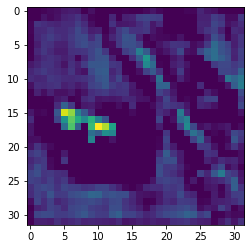

In [19]:
#What does the output looks like
#------------------------------------------------------
mydata = net.blobs['cascade192/output'].data
print(mydata.shape)
index = 0
output = np.squeeze(mydata[0,index,:,:])
plt.imshow(output)

print(np.min(output),np.max(output))

In [20]:
import caffe
net3 = caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/complete_model_gorchnet.prototxt',
                 '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-ROI.caffemodel',
                caffe.TEST)

In [227]:
# # load the output from net1 into net3
img_name = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.jpg'
txt_name = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.txt'


img = Image.open(img_name)

# This is the vusualization code
# draw = ImageDraw.Draw(img)
# draw.rectangle(((x_top, y_top), (x_bottom, y_bottom)))
# fig1,ax1 = plt.subplots(1)
# plt.title("GT Boxes")

# # for tmpRect in myProposedRects:

# rect = patches.Rectangle(
#         (x_top,y_top),
#         x_bottom - x_top,
#         y_bottom - y_top,
#         linewidth=2,
#         edgecolor='r',
#         facecolor='none')
# ax1.add_patch(rect)

# ax1.imshow(img)

# plt.show()

print("The original shape of the image is")
print(np.shape(img))

print("#" * 100)
print("resizing the image")

im_shape = np.shape(img)
imW = (im_shape[1])
imH = (im_shape[0])

target_size = 1      # change to 1 later
im_scaleX = float(target_size) / float(imW)
im_scaleY = float(target_size) / float(imH)

im = cv2.resize(im_orig, None, None, fx=im_scaleX, fy=im_scaleY, interpolation=cv2.INTER_LINEAR)
print("The new dimensions are")
print(np.shape(im))
# fig2,ax2 = plt.subplots(1)
# plt.title("Resized Image")
cord = x_top, y_top, x_bottom, y_bottom
xn_top, yn_top, xn_bottom, yn_bottom = normalized_cord(img,cord)

# This is the visualization code
rect = patches.Rectangle(
        (xn_top * target_size,yn_top * target_size),
        xn_bottom * target_size - xn_top * target_size,
        yn_bottom *target_size - yn_top * target_size,
        linewidth=2,
        edgecolor='g',
        facecolor='none')
ax2.add_patch(rect)
ax2.imshow(im)
plt.show()

The original shape of the image is
(334, 500, 3)
####################################################################################################
resizing the image


NameError: name 'im_orig' is not defined

In [22]:
x_top, y_top, x_bottom, y_bottom = get_cord(txt_name)
cord = x_top, y_top, x_bottom, y_bottom
img = Image.open(img_name)
target_size = 1
xn_top, yn_top, xn_bottom, yn_bottom = normalized_cord(img,cord)
xn_top*target_size, yn_top*target_size, xn_bottom*target_size, yn_bottom*target_size

(0.22876, 0.09581, 0.73808, 0.897)

In [206]:
# now load data into net3
data_list = []
label_list = [0, xn_top, yn_top, xn_bottom, yn_bottom] 
# label_list = [0, yn_top,  xn_top, yn_bottom, xn_bottom]   # This one gives better results, reverify!
data_list.append(mydata)
# net3.blobs['data'].reshape(*np.asarray(data_list).shape)
ll = np.asarray(label_list)
ll = np.reshape(ll,(1,1,1,5))
label_list = ll.tolist()
net3.blobs['data'].data[...] = data_list
net3.blobs['bboxes'].data[...] = label_list

In [207]:
class_output = net3.forward()
out =  net3.blobs['global_pool'].data
roi = net3.blobs['roi_pool'].data

In [208]:
net3.blobs['bboxes'].data[...]

array([[[[0.     , 0.22876, 0.09581, 0.73808, 0.897  ]]]], dtype=float32)

In [209]:
np.shape(net3.blobs['roi_pool'].data[...])

(1, 448, 8, 8)

(8, 8)
[[1.8735703e+00 9.7771454e-01 1.7522701e+00 2.2947464e+00 5.9286803e-01
  0.0000000e+00 3.4943035e-01 6.4637744e-01]
 [1.7541097e+00 7.9761320e-01 7.3758882e-01 1.9592418e-01 0.0000000e+00
  4.2009983e-02 1.3975965e+00 5.7750955e+00]
 [8.8505238e-01 1.5743237e+00 3.0556189e-02 0.0000000e+00 0.0000000e+00
  2.3588187e-01 3.8392588e-01 5.7980174e-01]
 [9.0479547e-01 1.5061011e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.1790822e+00 3.3983350e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.7703442e-01]
 [3.3841231e-01 8.5843384e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.5036772e-02 6.3279867e-02 2.6650479e-01]
 [0.0000000e+00 0.0000000e+00 3.4845304e-02 1.0603315e-01 1.5190347e-01
  1.7962458e-02 1.2956800e-01 5.1010382e-01]
 [8.9578627e-04 3.5051808e-02 1.0724398e-01 6.1775249e-01 1.8485377e+00
  2.9740584e-01 4.3698823e-01 1.2179136e-01]]
0.0 5.7750955


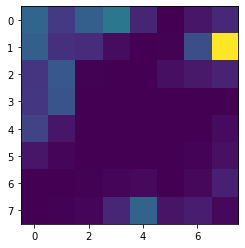

In [210]:
mydata = net3.blobs['roi_pool'].data
print(mydata[0,index,:,:].shape)
output = np.squeeze(mydata[0,index,:,])
plt.imshow(mydata[0,index,:,:])
print(mydata[0,index,:,:])
print(np.min(output),np.max(output))

In [104]:
out_label = class_output
np.shape(out)

(1, 128, 1, 1)

In [83]:
vec = np.reshape(out,(128))
print(vec)

[ 0.17830291  0.07952479 -0.21418741 -0.06227454  0.09372168  0.01521497
 -0.06353392  0.16989416 -0.01325516 -0.05272143  0.08584118  0.17476772
 -0.00894106 -0.08091862  0.08939848 -0.15335613 -0.06764771  0.12384898
  0.22420874 -0.00689631 -0.03766745  0.07829195  0.09173018 -0.12194443
 -0.06959507 -0.00449026  0.1335583  -0.18119629  0.011895   -0.08402536
 -0.15172172  0.31917965  0.079551   -0.21059169  0.0840864   0.12228817
 -0.13395119 -0.15925269 -0.0363506   0.02829336  0.12484621 -0.05402197
  0.11888821  0.2037022   0.01446846  0.0346273   0.08620663 -0.11672539
  0.14610264  0.01926462  0.18347742 -0.03338022  0.08330926  0.07957314
  0.10269584 -0.07703594 -0.02278947  0.03078528 -0.15615223  0.09196898
  0.1194497   0.04133487  0.0722731   0.28092745  0.00185678  0.05666072
 -0.13031515 -0.00964538 -0.06122872 -0.12268905  0.11601829  0.28142655
 -0.1735222   0.05344319  0.28767446 -0.12639852 -0.08095478  0.07436991
 -0.06015088  0.00337189  0.24263953 -0.19069864 -0

In [94]:
def net3(data, txt_file):
    x_top, y_top, x_bottom, y_bottom = get_cord(txt_file)
    cord = x_top, y_top, x_bottom, y_bottom
    img = Image.open(img_name)
    target_size = 1
    xn_top, yn_top, xn_bottom, yn_bottom = normalized_cord(img,cord)
    xn_top*target_size, yn_top*target_size, xn_bottom*target_size, yn_bottom*target_size
    data_list = []
    label_list = [xn_top, yn_top, xn_bottom, yn_bottom, 0]
    data_list.append(mydata)
    # net3.blobs['data'].reshape(*np.asarray(data_list).shape)
    ll = np.asarray(label_list)
    ll = np.reshape(ll,(1,1,1,5))
    label_list = ll.tolist()
    net3 = caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/complete_model_gorchnet.prototxt',
                 '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-ROI.caffemodel',
                caffe.TEST)
    net3.blobs['data'].data[...] = data_list
    net3.blobs['bboxes'].data[...] = label_list
    class_output = net3.forward()
    out =  net3.blobs['global_pool'].data
    return out
    
out = net3(mydata, txt_name)

In [95]:
vec = np.reshape(out,(128))
print(vec)

[ 1.68139681e-01  2.33121201e-01  1.26384348e-01 -5.89088500e-02
  4.11682203e-02  2.20284179e-01  1.83470145e-01  1.34981617e-01
  1.34788737e-01  2.39737108e-02 -5.25484569e-02  8.71543214e-02
 -7.35846460e-02 -6.10669442e-02  9.05436724e-02 -4.82168421e-02
 -1.57246977e-01  1.04664668e-01  9.44748893e-02  5.83240762e-05
  1.77080736e-01 -1.12778179e-01 -3.51925083e-02  1.44190580e-01
  1.88883441e-03  8.00492391e-02  4.45671044e-02 -4.87709185e-03
  1.72753900e-01 -1.17625788e-01 -1.25823721e-01  9.69428867e-02
 -2.21166685e-01  4.01069820e-02 -1.29300570e-02 -2.24603534e-01
  1.04673736e-01 -1.41550496e-01 -1.42613977e-01  1.16897918e-01
 -8.26550424e-02  1.04966953e-01 -5.62056750e-02  1.95360500e-02
  3.64081794e-03  6.13303259e-02 -1.89880461e-01  7.38156512e-02
  1.53212026e-01  1.46900326e-01  1.29013896e-01 -1.47685871e-01
  6.95815012e-02  1.96774676e-01  5.23239449e-02 -8.19169655e-02
  2.01359197e-01 -7.99157545e-02  1.00055404e-01 -8.84114951e-02
  1.62154227e-01  6.93668

131


In [120]:
data[0][1]

['squirrel', array([ 84.59589, 235.60592, 465.71729, 362.30111])]